# Logistic Regression from Scratch: An Immersion to Machine Learning Concepts

**Dimitrios Tanoglidis**

This is the first of a series of notebooks on basic Machine Learning algorithms, written (when relatively easy) from scratch. That means that I will try to avoid using the [scikit-learn](https://scikit-learn.org/stable/) library, at least not before writing my own functions first. 

The reason for writing these notebooks is the same as the reason one teaches a class: to learn the material themselves. That being said, I hope that other people will find them useful, too. 


The first algorithm I am going to present is the logistic regression classifier (yes, although it has the name "regression", it is a classifier). The reason for selecting LR as the first classifier to present is that:

- a) It is intuitive 

- b) Often works "just fine" for practical applications (useful skill for industry-oriented people) 

-  c) Can be easily coded from scratch

-  d) It is (usually) the last layer of a deep neural network

- e) Allow us to introduce concepts such as regularization, and selection of hyperparameters

- f) Allow us to nicely introduce and hard-code the loss function and its optimization methods 

- g) and many more!!!




Before discussing the model, let's import all the necessary packages we are going to need.




In [3]:
# Basic packages and plotting
import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import pandas as pd
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()


# =============================================
# Scikit-learn etc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

If you run this notebook on Colab, uncomment and run the following cell

In [4]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super

## Logistic Regression for binary classification

LR is a **supervised** machine learning classifier. We will consider a binary classification problem. Assume that we have $m$ training pairs $(\mathbf{x}^{(i)},y^{(i)})$, where $\mathbf{x}^{(i)} = [x_1^{(i)},x_1^{(i)},\dots,x_n^{(i)}]$ a feature vector and the labels $y^{(i)} \in \{0,1\}$, the probability to get $y=1$ is modeled as:


\begin{equation}\boxed{
p(y=1|\mathbf{x};\mathbf{w}) = \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}},}
\end{equation}

where $\mathbf{w}^T\mathbf{x} = \sum_{i=0}^n w_i x_i = w_0 + w_1 x_1 + \dots + w_n x_n $.

The parameters $w$ are **weights to be learned**. Specifically the paramter $w_0$ is called **bias**.

The property that makes the logistic function (also known as **sigmoid**) $\sigma(z) = 1/(1+e^{-z})$ useful is that it can take number (here $\mathbf{w}^T\mathbf{x}$) and map it to the interval $(0,1)$, thus making it easy to be interpreted as probability.

Let's plot the logistic function in a range of $z$ values:


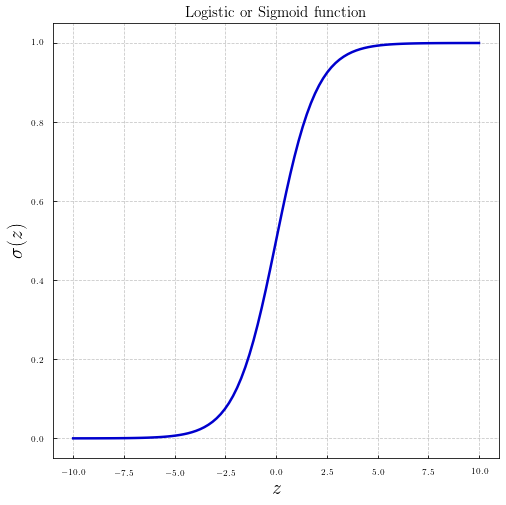

In [5]:
def logist(z):
    g = 1. + np.exp(-z)
    return 1./g


z = np.linspace(-10,10,100)
logist_z = logist(z)


plt.figure(figsize = (8.0,8.0))
plt.plot(z,logist_z,c='mediumblue',linewidth=2.5)
plt.grid(ls='--',alpha=0.7)
plt.title('Logistic or Sigmoid function', fontsize=15)
plt.xlabel('$z$',fontsize=20)
plt.ylabel('$\sigma(z)$', fontsize=20)

plt.show()


### Learning the weights: An introduction to the loss function and the gradient descent

#### The loss function

If we find optimal weights, $w$, then the predicted label of a single observation, $\hat{y}$, will be:


\begin{equation}
\hat{y} = \begin{cases} 
1, & \mbox{if}\,\, \sigma(\mathbf{w^Tx}) \geq 0.5 \\ 
0, & \mbox{otherwise}
\end{cases}
\end{equation}

How are we going to find the weights? 

Since we are dealing with a binary problem, labels $Y \in \{0,1\}$ the probability to get label $y$ when we have an observation $\mathbf{x}$ is given by the **Bernoulli distribution**:


\begin{equation}
p(y|\mathbf{x};\mathbf{w}) \\= p(y=1|\mathbf{x};\mathbf{w})^y (1- p(y=1|\mathbf{x};\mathbf{w}))^{(1-y)}  \\=\sigma(\mathbf{w^Tx})^y (1 - \sigma(\mathbf{w^Tx}))^{(1-y)}
\end{equation}

Assuming that the $m$ training samples are independent, we can write down a **likelihood** of parameters given observations, whose **maximization** will yield the best set  of parameters:

\begin{equation}
L(\mathbf{w}|\mathbf{x},\mathbf{y}) = \prod_{i=1}^m p(y^{(i)}|\mathbf{x}^{(i)};\mathbf{w}) \\ = \prod_{i=1}^m \sigma(\mathbf{w^Tx}^{(i)})^{y^{(i)}} (1 - \sigma(\mathbf{w^Tx}^{(i)}))^{(1-y^{(i)})}
\end{equation}

Now to form the **loss function** (something to be **minimized**) we will get the *negative* of the the log of the above likelihood (the logarithm is for computational ease):

\begin{equation}
\boxed{
J(\mathbf{w}) = - \frac{1}{m}\sum_{i=1}^m y^{(i)}\log \sigma(\mathbf{w^Tx}^{(i)}) + (1-y^{(i)})\log (1 - \sigma(\mathbf{w^Tx}^{(i)}))}
\end{equation}


This is also known as the **binary cross-entropy** loss function (note that we have averaged over all samples). 

(For the name cross-entropy check the relevant [wikipedia article](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression))



Let's write a function that implements gradient descent for logistic regression and apply it to the problem of star-galaxy separation from SDSS data


#### Gradient descent

It is not possible to get an expression for the parameters that minimize $J(\mathbf{w})$ in a closed form. 

For that readon we will use the **gradient descent** algorithm, which is an iterative process to update the weights:

\begin{equation}
\boxed{
\mathbf{w} \leftarrow \mathbf{w} - \eta \nabla_\mathbf{w} J(\mathbf{w})}
\end{equation}

(till convergence or for a fixed number of steps). The (hyper)parameter $\eta$ is knows as the **learning rate**, and dictates how much the weights are being updated in each iteration of the algorithm. 

The intuition behind this is that we are moving towards the region that the function $J$ changes more rapidly each time.

The above equation can be also written in terms of the components of the weights vector as:

\begin{equation}
w_j \leftarrow w_j - \eta \frac{\partial J}{\partial w_j}, \quad j=0, \dots, n
\end{equation}

$n$ being the number of features (remember $w_0$ is the bias factor).


For the case of the logistic loss function, one can show that (see appendix):

\begin{equation}
\frac{\partial J}{\partial w_j} = \frac{1}{m}\sum_{i=1}^m \left[ \sigma(\mathbf{w^Tx}^{(i)}) - y^{(i)}\right]x_j^{(i)}
\end{equation}

with $x_j^{(i)}$ the $j$-th component of the feature vector of the $i$-th example, and $x_0^{(i)} = 1$.

Summarizing, we can **learn** the optimal weights, given a training set $(x^{(i)},y^{(i)})$ of size $m$, in an iterative way, as:


\begin{equation}
\boxed{
w_j \leftarrow w_j - \eta \frac{1}{m}\sum_{i=1}^m \left[ \sigma(\mathbf{w^Tx}^{(i)}) - y^{(i)}\right]x_j^{(i)}}
\end{equation}


A catalog of SDSS instances

In [6]:
# Import the data
SDSS_table = pd.read_csv("SDSS_file.csv")
SDSS_table.head()

,objid,ra,dec,u,g,r,i,z,specobjid,class,redshift
0,1237646798137787517,121.802126,0.855476,25.02634,21.90814,20.17926,19.22341,18.68446,5342652717419438080,GALAXY,0.504717
1,1237646798137787833,121.748271,0.891010,23.74677,22.75365,21.10284,20.06169,19.50690,5342652167663624192,GALAXY,0.579273
2,1237646798137788079,121.708487,0.874751,23.15607,22.95075,20.89328,19.71096,19.10471,5342651617907810304,GALAXY,0.772647
3,1237646798137852371,121.820752,0.931990,19.37035,17.34262,16.35286,15.92400,15.58903,5342663162779901952,GALAXY,0.101993
4,1237646798137852646,121.910430,0.896389,23.42736,22.81119,20.27570,19.14886,18.67588,5342662613024088064,GALAXY,0.585733


In [7]:
# Get the redshift
redshift = SDSS_table["redshift"]
# Get the magnitudes
u = SDSS_table["u"];g = SDSS_table["g"];r = SDSS_table["r"];i = SDSS_table["i"];z =SDSS_table["z"]
class_obs = SDSS_table["class"]

class_label = np.zeros(len(class_obs))

Now change the class of objects to something that a machine can understand. Say "GALAXY" = 0, "STAR" = 1, "QSO"=2

In [8]:
for i_l in range(len(class_label)):
    
    if (class_obs[i_l]=="GALAXY"):
        class_label[i_l] = 0
    elif (class_obs[i_l]=="STAR"):
        class_label[i_l] = 1
    else:
        class_label[i_l] = 2

In [9]:
cuts = (u>-10.)&(g>-10.)&(r>-10.0)&(i>-10.0)&(z>-10.0)

u = u[cuts]
g = g[cuts]
r = r[cuts]
i = i[cuts]
z = z[cuts]
redshift = redshift[cuts]
class_label = class_label[cuts]
print(len(redshift))

299908


Now let's create some extra features, beyond the raw magnitudes we imported above. Namely the colors and the magnitude ratios.

The colors are $u-g$, $u-r$, $u-i$, $u-z$, $g-r$, $g-i$, $g-z$, $r-i$, $r-z$

And the ratios, similarly: $u/g$, $u/r$, $u/i$, $u/z$, $g/r$, $g/i$, $g/z$, $r/i$, $r/z$.

In [10]:
# Define colors first 
u_g = u-g; u_r = u-r; u_i = u-i; u_z = u-z; g_r = g-r; g_i = g-i; g_z = g-z; r_i = r-i; r_z = r-z
# Define the ratios now
u_ov_g = u/g; u_ov_r = u/r; u_ov_i = u/i; u_ov_z = u/z; g_ov_r = g/r; g_ov_i = g/i; g_ov_z=g/z; r_ov_i = r/i
r_ov_z = r/z

Now create a feature matrix.

In [11]:
n_inst = len(redshift) #number of examples

# Initialize feature matrix
X_feat = np.zeros([n_inst,23])
# ================================================================
# ================================================================
# Define feature matrix
X_feat[:,0] = u;X_feat[:,1] = g; X_feat[:,2] = r; X_feat[:,3] = i; X_feat[:,4] =z
X_feat[:,5] = u_g;X_feat[:,6] = u_r;X_feat[:,7] = u_i;X_feat[:,8] = u_z; X_feat[:,9] = g_r
X_feat[:,10] = g_i; X_feat[:,11] = g_z; X_feat[:,12] = r_i; X_feat[:,13] = r_z
X_feat[:,14] = u_ov_g; X_feat[:,15] = u_ov_r; X_feat[:,16] = u_ov_i; X_feat[:,17] = u_ov_z
X_feat[:,18] = g_ov_r;X_feat[:,19] = g_ov_i;X_feat[:,20] = g_ov_z
X_feat[:,21] = r_ov_i; X_feat[:,22] = r_ov_z

Now, keep only stars and galaxies

In [12]:
X_ft_new = X_feat[(class_label==0.0)|(class_label==1.0),:]
y_label_new = class_label[(class_label==0.0)|(class_label==1.0)]

X_ft = X_ft_new[:3000,:]
y_true = y_label_new[:3000]

print(len(y_true[y_true==1]))


# Also reserve a test matrix
X_test = X_ft_new[4000:5000,:]
y_test = y_label_new[4000:5000]

1148


Define function that fits the logistic regression

In [21]:
def Logistic_fit(X, y, eta=0.001, n_iter=10000):
    """
    Fits data to a LR model and returns weights
    
    X -> feature matrix [n_samples,n_features]
    y -> true labels [n_samples]
    eta -> learning rate
    n_iter -> number of iterations
    """    
    
    
    n_feats = np.shape(X)[1] # number of features
    m_samples = np.shape(X)[0] # number of samples (instances)
    
    # Initialize weights
    w = np.random.normal(0,0.5,n_feats+1)
    
    for i in range(n_iter):
        
        z_inp = np.dot(X,w[1:]) + w[0]
        # Predictions - output of the sigmoid function
        sigma_lr = 1./(1.+np.exp(-np.clip(z_inp,-200,200)))
        # Errors 
        err = (sigma_lr - y)
        
        # Update weights
        w[1:] -= (eta/m_samples)*(np.dot(X.T,err))
        w[0] -= (eta/m_samples)*(err.sum())
        
    return w

In [22]:
weights = Logistic_fit(X_ft,y_true)

def predict_LR(w,X):
    n_samples = np.shape(X)[0]
    
    z_inp = np.dot(X,w[1:]) + w[0]
    sig_out = 1./(1.+np.exp(-np.clip(z_inp,-200,200)))
    
    y_pr = np.zeros(n_samples)
    y_pr[sig_out>0.5] = 1
    
    return(y_pr)

y_pred = predict_LR(weights,X_test)

In [23]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.899
0.8181818181818182
0.8773584905660378


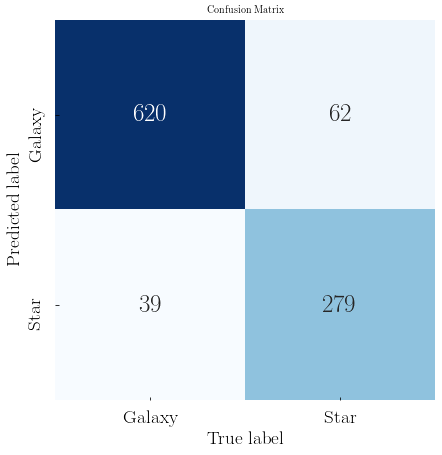

In [24]:
import seaborn as sns

con_mat = confusion_matrix(y_test, y_pred).T
con_mat = con_mat.astype(float)
class_names = ['Galaxy', 'Star']


plt.figure(figsize = (7.0,7.0))
plt.title('Confusion Matrix',fontsize=10)
g =sns.heatmap(con_mat.T, square = True, annot=True,fmt='.0f',annot_kws={"size": 25}, cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

g.set_xticklabels(class_names, fontsize = 19)
g.set_yticklabels(class_names, fontsize = 19)

plt.xlabel('True label',fontsize=19)
plt.ylabel('Predicted label',fontsize=19)

plt.show()

## References